# PCA Tutorial
Author: [Kathleen Clark](https://becksteinlab.physics.asu.edu/people/75/kathleen-clark) ([@kaceyreidy](https://github.com/kaceyreidy))

Principal component analysis (PCA) is a method of converting one corrdinate system into another where the data as represented by the resulting coordinate system is uncorrelated. The resulting coordinates are ordered such that the first principal component (coordinate axis) accounts for the most variation in the data, the second prinicpal component accounts for the most variation that it can while being perpendicular to the first, and so on. ([Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis))

In this tutorial we use [MDAnalysis](https://mdanalysis.org) to show how to use PCA to analyze and visualize large macromolecular conformational changes. As example we use the closed -> open transition of the enzyme adenylate kinase (AdK). The AdK trajectory is included with the MDAnalysis test data.

## Conducting PCA

First let's import all of the necessary modules.

In [1]:
import MDAnalysis as mda
import MDAnalysis.analysis.pca as pca
from MDAnalysis.coordinates.base import Timestep
from MDAnalysisTests.datafiles import PSF, DCD

import numpy as np
import os
import glob

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.ticker as ticker
%matplotlib inline

Now, let's define our paths and some our analysis preferences.

- save data in the _PCA_tutorial_ directory
- use the protein backbone atoms for the analysis (selection "backbone")
- analyze every step in the trajectory
- visualize the first 5 principal components (`npc = 5`)

In [2]:
datapath = os.path.join('PCA_tutorial', 'AdK')
selection = 'backbone'
stepsize = 1
npc = 5


os.makedirs(datapath, exist_ok=True)
for dirname in ('pcs', 'variances', 'cumulative_variances', 
                'mean_atoms', 'transforms', 
                os.path.join('trajectories', 'PC'),
                'images'):
    os.makedirs(os.path.join(datapath, dirname), exist_ok=True)

Let's make a universe object of our trajectory.

In [3]:
u = mda.Universe(PSF, DCD)
ag = u.select_atoms(selection)

Let's conduct principal component analysis of the trajectory.

[pca.PCA](http://www.mdanalysis.org/mdanalysis/documentation_pages/analysis/pca.html#pca-tutorial) creates a pca object which has all of the properties that we will need to use.

In [4]:
pc = pca.PCA(u, select=selection, align=True, verbose=True, step=stepsize)
pc.run()

Mean Calculation Step   98/98 [100.0%]
Step    98/98 [100.0%]


The PCA object computes the eigenvectors of the corrdinate matrix in our protein universe (using numpy.linalg.eig); this calculation may take a few seconds. Let's save these principal component vectors themselves.

In [5]:
pc_pc = pc.p_components
np.save(os.path.join(datapath, 'pcs', 'pcomponents.npy'), pc_pc)

We should also save the variance and cumulative variance data for later analysis.

The corresponding eigenvalue to each of these eigenvectors is equivalent to that eigenvector's variance.

In [6]:
pc_vars = pc.variance
np.save(os.path.join(datapath,'variances', 'vars.npy'), pc_vars)

The cumulative variance of one of the prinicipal components is the variance or eigenvalue associated with that component summed with all of the preceding variances.

How much of the total variance is capture by the first `npc` PCs?

In [7]:
pc.cumulated_variance[npc]

0.9995688529548218

In [8]:
npc

5

Save the data for later.

In [9]:
pc_cvars = pc.cumulated_variance
np.save(os.path.join(datapath, 'cumulative_variances',
                     'cumulativevars.npy'), pc_cvars)

Finally, let's save the average position of the atoms.

In [10]:
pc_ma = pc.mean_atoms
pc_ma.write(os.path.join(datapath, 'mean_atoms' , 'meanatoms.pdb'))

/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


## Creating projections

We can now convert our original simulation data into the principal component coordinate system to view it in a new way.

Now, we need to project the original projectory onto the principal components and store the projected data.

$Y(t)=\sum_{i=0}^{m}((X(t)-\overline X) \cdot u_i)u_i+\overline X$ where

$Y(t)$ is the projected trajectory,

$X(t)$ is the original trajectory,

$u_i$ is the principal component $i$, and

$\overline X$ is the coordinates of the average structure.

`pca.transform()` computes the weights $w_i(t) = (X(t)-\overline X) \cdot u_i$ for each principal component $i$.

In [11]:
pc_transform = pc.transform(ag, n_components=npc)
np.save(os.path.join(datapath, 'transforms', str(npc)+'components.npy'), pc_transform)

## Analyzing Data

First, let's load our newly projected data.

In [12]:
tpcs = np.load(os.path.join(datapath, 'transforms', 
                            str(npc)+'components.npy'))

We want to store this data into a more usable format, a pandas DataFrame, so we need to make a list of the columns we want to have.

In [13]:
columns=[]
for i in range(npc):
    columns.append('PC'+str(i))

Next, let's put our data into a DataFrame and set the index to be an indicator of time.

In [14]:
df = pd.DataFrame(tpcs, columns=columns)
df['time']=df.index
df = df.reset_index(drop=True)
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df = df[::stepsize]

Now, we can use seaborn's PairGrid function to create a grid of principal component graphs.

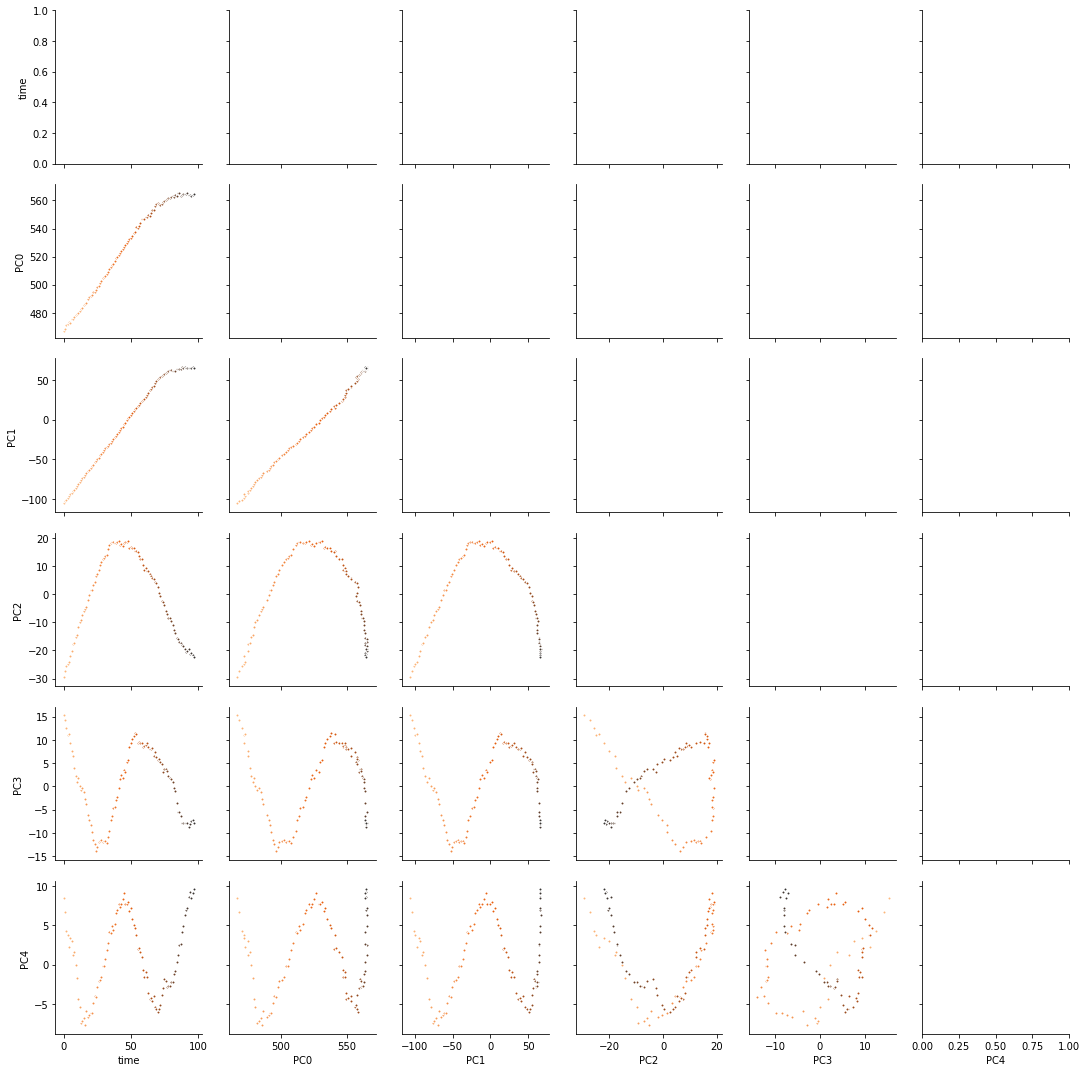

In [15]:
g = sns.PairGrid(df, hue='time', 
                 palette=reversed(sns.color_palette('Oranges_d', n_colors=len(df))))
g.map_lower(plt.scatter, edgecolor="white", marker='.')
g.savefig(os.path.join(datapath,'images', 'PCs.pdf'))
g.savefig(os.path.join(datapath,'images', 'PCs.png'))

We can also look at plots of the cumulative variance to visualize our data.

In [16]:
cvars = np.load(os.path.join(datapath, 'cumulative_variances', 'cumulativevars.npy'))

We need to create an axes object and set some labels, and then we can graph the cumulative variance.

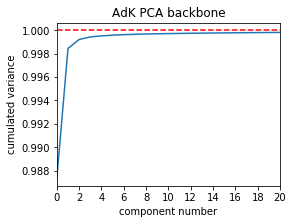

In [17]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.set_title('AdK PCA '+selection)
ax.set_xlabel('component number')
ax.set_ylabel('cumulated variance')
ax.set_xlim(None, 20)
ax.plot(cvars)
ax.axhline(y=1, color='r', linestyle='--')
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

Finally, we can save this plot.

In [18]:
ax.figure.savefig(os.path.join(datapath, 'images', 'cumulative_variances.pdf'))
ax.figure.savefig(os.path.join(datapath, 'images', 'cumulative_variances.png'))

## Visualizing Projections

We want to project the original trajectory on the principal components, i.e., we want to see the motions of the protein that are contained in the PC. The first few PCs contain most of the motion so large conformational changes should be obvious in the first few projections. Smaller scale motions should be filtered out.

But first we need to finish the rest of the projection from where pca.transform leaves off.

First, let's load the data we saved.

In [19]:
pc_components = np.load(os.path.join(datapath, 'pcs' ,'pcomponents.npy'))
u_mean = mda.Universe(os.path.join(datapath, 'mean_atoms', 'meanatoms.pdb'))

/Users/oliver/anaconda3/envs/mda3/lib/python3.6/site-packages/MDAnalysis/topology/PDBParser.py:301: UserWarning: PDB file contained CONECT record to TER entry. These are not included in bonds.
  "PDB file contained CONECT record to TER entry. "


We also need to set the size of the projected trajectory and get some other data about our initial conditions.

In [20]:
start, stop, step = u.trajectory.check_slice_indices(None, None, 1)
n_frames = len(range(start, stop, step))
n_components = pc_components.shape[1]
n_atoms = int(pc_components.shape[0]/3)

We also need the principal component space.

In [21]:
space = np.load(os.path.join(datapath, 'transforms', str(npc)+'components.npy'))

Next, we need to iterate over each component and for each component calculate the position of the atoms along that axis for each timestep. Then we write the new positions to a trajectory (here in DCD format). There will be one trajectory for each of the `npc` PCs.

In [22]:
components = pc_components[:, :npc]
for component in range(components.shape[1]):
    yc = np.zeros((n_frames, components.shape[0]))
    for time, weights in enumerate(space):
        for atom in range(components.shape[0]):
            yc[time, atom] = weights[component] * components[atom, component]
    yc = yc.reshape(n_frames, n_atoms, 3)

    with mda.Writer(os.path.join(datapath, 'trajectories', 'PC', 
                                 str(component+1)+'.dcd'), 
                    n_atoms=n_atoms) as f:
        ts = Timestep(n_atoms=n_atoms, dt=1)
        for pos in yc:
            ts.positions = u_mean.atoms.positions + pos
            f.write(ts)

The resulting trajectories show the original data filtered on the first to fifth PC.

View the trajectory, e.g., component 2
```
vmd PCA_tutorial/AdK/mean_atoms/meanatoms.pdb PCA_tutorial/AdK/trajectories/PC/2.dcd
```
(or using nglviewer TODO)